In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')


import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import load_npz

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from umap import UMAP

import diffusion_dist as diff
import dataset as dataset
import model as model
import loss as loss
import train as train
import utils as utils
import post_align as palign
import benchmark as bmk
import TI as ti
import networkx as nx
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train model

In [ ]:
# all in one
seeds = [0]
latent_dim = 4
learning_rate = 3e-4
n_epochs = 500
use_anchor = False
reg_d = 1
reg_g = 1
reg_mmd = 1
ts = [30, 50, 70]
use_potential = True

counts_rna = pd.read_csv("../data/Endo/counts_rna.csv", index_col = 0)
counts_atac = pd.read_csv("../data/Endo/counts_atac.csv", index_col = 0)
label_rna = pd.read_csv("../data/Endo/anno_rna.txt", header = None)
label_atac = pd.read_csv("../data/Endo/anno_atac.txt", header = None)
rna_dataset = dataset.dataset(counts = counts_rna.values, anchor = None)
atac_dataset = dataset.dataset(counts = counts_atac.values, anchor = None)
coarse_reg = pd.read_csv("../data/Endo/region2gene.csv", sep = ",", index_col = 0).values


scDART_op = scDART.scDART(n_epochs = n_epochs, latent_dim = latent_dim, \
        ts = ts, use_anchor = use_anchor, use_potential = use_potential, k = 10, \
        reg_d = 1, reg_g = 1, reg_mmd = 1, l_dist_type = 'kl', seed = seeds[0],\
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

scDART_op = scDART_op.fit(rna_count = counts_rna.values, atac_count = counts_atac.values, reg = coarse_reg, rna_anchor = None, atac_anchor = None)
z_rna, z_atac = scDART_op.transform(rna_count = counts_rna.values, atac_count = counts_atac.values, rna_anchor = None, atac_anchor = None)


In [3]:
# # step by step
# seeds = [0]
# latent_dim = 4
# learning_rate = 3e-4
# n_epochs = 500
# use_anchor = False
# reg_d = 1
# reg_g = 1
# reg_mmd = 1
# ts = [30, 50, 70]
# use_potential = True

# seed = seeds[0]
# print("Random seed: " + str(seed))
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# np.random.seed(seed)

# counts_rna = pd.read_csv("../data/Endo/counts_rna.csv", index_col = 0)
# counts_atac = pd.read_csv("../data/Endo/counts_atac.csv", index_col = 0)
# label_rna = pd.read_csv("../data/Endo/anno_rna.txt", header = None)
# label_atac = pd.read_csv("../data/Endo/anno_atac.txt", header = None)
# rna_dataset = dataset.dataset(counts = counts_rna.values, anchor = None)
# atac_dataset = dataset.dataset(counts = counts_atac.values, anchor = None)
# coarse_reg = torch.FloatTensor(pd.read_csv("../data/Endo/region2gene.csv", sep = ",", index_col = 0).values).to(device)

# batch_size = int(max([len(rna_dataset),len(atac_dataset)])/4)

# train_rna_loader = DataLoader(rna_dataset, batch_size = batch_size, shuffle = True)
# train_atac_loader = DataLoader(atac_dataset, batch_size = batch_size, shuffle = True)


# EMBED_CONFIG = {
#     'gact_layers': [atac_dataset.counts.shape[1], 1024, 512, rna_dataset.counts.shape[1]], 
#     'proj_layers': [rna_dataset.counts.shape[1], 512, 128, latent_dim], # number of nodes in each 
#     'learning_rate': learning_rate,
#     'n_epochs': n_epochs + 1,
#     'use_anchor': use_anchor,
#     'reg_d': reg_d,
#     'reg_g': reg_g,
#     'reg_mmd': reg_mmd,
#     'l_dist_type': 'kl',
#     'device': device
# }


# # calculate the diffusion distance
# dist_rna = diff.diffu_distance(rna_dataset.counts.numpy(), ts = ts,
#                                 use_potential = use_potential, dr = "pca", n_components = 30)

# dist_atac = diff.diffu_distance(atac_dataset.counts.numpy(), ts = ts,
#                                 use_potential = use_potential, dr = "lsi", n_components = 30)


# dist_rna = dist_rna/np.linalg.norm(dist_rna)
# dist_atac = dist_atac/np.linalg.norm(dist_atac)
# dist_rna = torch.FloatTensor(dist_rna).to(device)
# dist_atac = torch.FloatTensor(dist_atac).to(device)

# # initialize the model
# gene_act = model.gene_act(features = EMBED_CONFIG["gact_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
# encoder = model.Encoder(features = EMBED_CONFIG["proj_layers"], dropout_rate = 0.0, negative_slope = 0.2).to(device)
# model_dict = {"gene_act": gene_act, "encoder": encoder}

# opt_genact = torch.optim.Adam(gene_act.parameters(), lr = learning_rate)
# opt_encoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
# opt_dict = {"gene_act": opt_genact, "encoder": opt_encoder}

# # training models
# train.match_latent(model = model_dict, opts = opt_dict, dist_atac = dist_atac, dist_rna = dist_rna, 
#                 data_loader_rna = train_rna_loader, data_loader_atac = train_atac_loader, n_epochs = EMBED_CONFIG["n_epochs"], 
#                 reg_mtx = coarse_reg, reg_d = EMBED_CONFIG["reg_d"], reg_g = EMBED_CONFIG["reg_g"], reg_mmd = EMBED_CONFIG["reg_mmd"], use_anchor = EMBED_CONFIG["use_anchor"], norm = "l1", 
#                 mode = EMBED_CONFIG["l_dist_type"])

# with torch.no_grad():
#     z_rna = model_dict["encoder"](rna_dataset.counts.to(device)).cpu().detach()
#     z_atac = model_dict["encoder"](model_dict["gene_act"](atac_dataset.counts.to(device))).cpu().detach()


# with torch.no_grad():
#     z_rna, z_atac = palign.match_alignment(z_rna = z_rna, z_atac = z_atac, k = 10)
#     z_atac, z_rna = palign.match_alignment(z_rna = z_atac, z_atac = z_rna, k = 10)


Random seed: 0
running time(sec): 1.3281676769256592
running time(sec): 1.4059581756591797
running time(sec): 1.3401319980621338
running time(sec): 0.5810019969940186
running time(sec): 0.580620288848877
running time(sec): 0.5869541168212891
epoch:  0
	 mmd loss: 0.027
	 ATAC dist loss: 0.657
	 RNA dist loss: 0.342
	 gene activity loss: 5077.949
	 anchor matching loss: 0.000
epoch:  100
	 mmd loss: 0.024
	 ATAC dist loss: 0.025
	 RNA dist loss: 0.024
	 gene activity loss: 25.837
	 anchor matching loss: 0.000
epoch:  200
	 mmd loss: 0.024
	 ATAC dist loss: 0.018
	 RNA dist loss: 0.018
	 gene activity loss: 16.632
	 anchor matching loss: 0.000
epoch:  300
	 mmd loss: 0.023
	 ATAC dist loss: 0.016
	 RNA dist loss: 0.018
	 gene activity loss: 12.242
	 anchor matching loss: 0.000
epoch:  400
	 mmd loss: 0.020
	 ATAC dist loss: 0.015
	 RNA dist loss: 0.017
	 gene activity loss: 9.554
	 anchor matching loss: 0.000
epoch:  500
	 mmd loss: 0.021
	 ATAC dist loss: 0.014
	 RNA dist loss: 0.016
	 

# Plot results

None
None


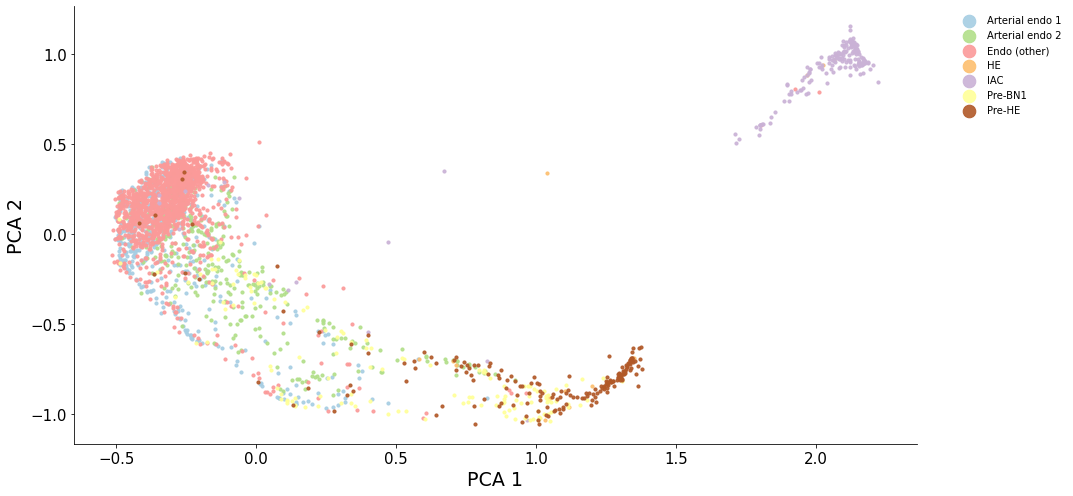

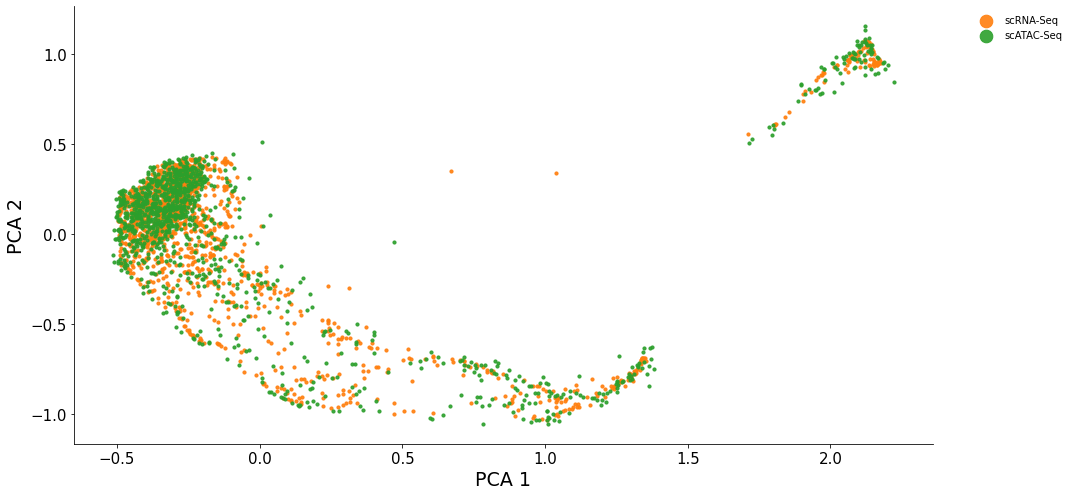

In [8]:
# post-maching
pca_op = PCA(n_components = 2)
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna_pca = z[:z_rna.shape[0],:]
z_atac_pca = z[z_rna.shape[0]:,:]
_ = utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
                    anno2 = label_atac, mode = "joint", save = None, 
                    figsize = (15,7), axis_label = "PCA")
_ = utils.plot_latent(z1 = z_rna_pca, z2 = z_atac_pca, anno1 = label_rna, 
                    anno2 = label_atac, mode = "modality", save = None, 
                    figsize = (15,7), axis_label = "PCA")


# Infer trajectory

running Leiden clustering
finished
None


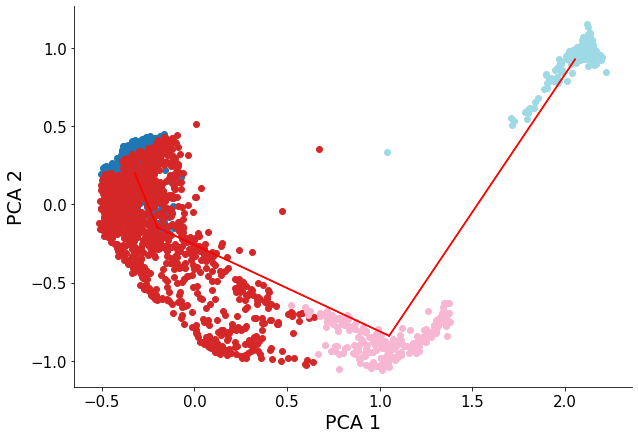

In [9]:
# define the root cell
root_cell = 35

# infer the trajectory backbone 
groups, mean_cluster, T = ti.backbone_inf(np.concatenate((z_rna, z_atac), axis = 0), resolution = 0.05)
groups_rna = groups[:counts_rna.shape[0]]
groups_atac = groups[counts_rna.shape[0]:]
root_clust = groups[root_cell]

G = nx.from_numpy_matrix(T, create_using=nx.DiGraph)
G = nx.dfs_tree(G, source = root_clust)
paths = []
for node in G:
    if G.out_degree(node)==0: #it's a leaf
        paths.append(nx.shortest_path(G, root_clust, node))
        
pca_op = PCA(n_components = 2)
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna_pca = z[:z_rna.shape[0],:]
z_atac_pca = z[z_rna.shape[0]:,:]    
mean_cluster = pca_op.transform(np.array(mean_cluster))
utils.plot_backbone(z_rna_pca, z_atac_pca, groups = groups, T = T, mean_cluster = mean_cluster, mode = "joint", figsize=(10,7), save = None, axis_label = "PCA")


None


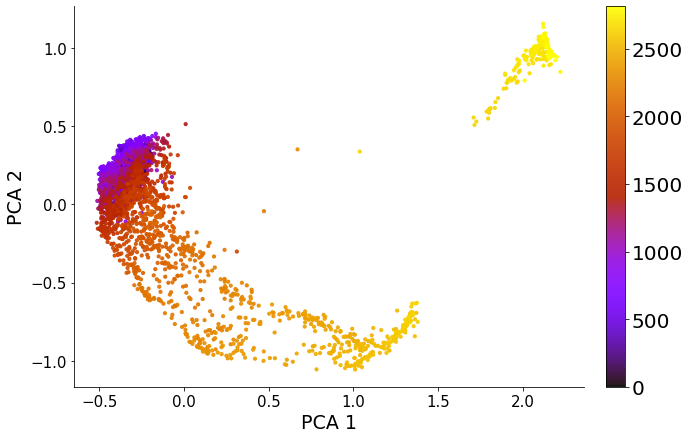

In [12]:
# infer pseudo-time
dpt_mtx = ti.dpt(np.concatenate((z_rna, z_atac), axis = 0), n_neigh = 10)
pt_infer = dpt_mtx[root_cell, :]
pt_infer[pt_infer.argsort()] = np.arange(len(pt_infer))
pt_infer = pt_infer/np.max(pt_infer)
# for scRNA-Seq batch
pt_infer_rna = pt_infer[:z_rna.shape[0]]
# for scATAC-Seq batch
pt_infer_atac = pt_infer[z_rna.shape[0]:]
utils.plot_latent_pt(z1 = z_rna_pca, z2 = z_atac_pca, pt1 = pt_infer_rna, pt2 = pt_infer_atac, mode = "joint", save = None, figsize = (10,7), axis_label = "PCA")
